In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [22]:
import attr
import re
import numpy as np

from collections import Counter, defaultdict
from itertools import islice
from boltons.iterutils import windowed
from tqdm import tqdm_notebook

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
class Corpus:
    
    def __init__(self, path, skim=None):
        self.path = path
        self.skim = skim
        
    def lines(self):
        with open(self.path) as fh:
            for line in fh:
                yield line.strip()
    
    def abstract_lines(self):
        lines = []
        for line in self.lines():
            if line:
                lines.append(line)
            else:
                yield lines
                lines = []

    def abstracts(self):
        ab_lines = self.abstract_lines()
        if self.skim:
            ab_lines = islice(ab_lines, self.skim)
        for lines in ab_lines:
            yield Abstract.from_lines(lines)
            
    def xy(self, vocab):
        for abstract in self.abstracts():
            yield from abstract.xy(vocab)
            
    def ngram_counts(self, n):
        counts = defaultdict(lambda: 0)
        for ab in self.abstracts():
            for sent in ab.sentences:
                for ngram in sent.ngrams(n):
                    counts[ngram] += 1
        return Counter(counts)
            
    def most_common_ngrams(self, n, depth):
        counts = self.ngram_counts(n)
        return set([k for k, _ in counts.most_common(depth)])

In [3]:
@attr.s
class Abstract:
    
    identifier = attr.ib()
    tags = attr.ib()
    sentences = attr.ib()
    
    @classmethod
    def from_lines(cls, lines):
        sentences = list(map(Sentence, lines[2:]))
        return cls(lines[0], lines[1].split(), sentences)
    
    def sentence_tokens(self):
        for sent in self.sentences:
            yield re.findall('[a-z]+', sent.lower())
    
    def xy(self, vocab):
        for i, sent in enumerate(self.sentences):
            x = sent.features(vocab)
            y = i / (len(self.sentences)-1)
            yield x, y

In [4]:
class Sentence(str):
    
    def ngrams(self, n=1):
        for ng in windowed(re.findall('[a-z]+', self.lower()), n):
            yield '_'.join(ng)
            
    def ngram_counts(self, vocab, maxn=3):
        for n in range(1, maxn+1):
            counts = Counter(self.ngrams(n))
            for k, v in counts.items():
                if k in vocab:
                    yield f'_{k}', v
                    
    def word_count(self):
        return len(list(self.ngrams(1)))
                
    def _features(self, vocab):
        yield from self.ngram_counts(vocab)
        yield 'word_count', self.word_count()
        
    def features(self, vocab):
        return dict(self._features(vocab))

In [5]:
train = Corpus('../data/abstracts/train.txt', 100000)

In [6]:
vocab = (
    train.most_common_ngrams(1, 2000) |
    train.most_common_ngrams(2, 2000) |
    train.most_common_ngrams(3, 2000)
)

In [7]:
dv = DictVectorizer()

In [8]:
train_x, train_y = zip(*train.xy(vocab))

In [9]:
train_x = dv.fit_transform(train_x)

In [10]:
train_x

<537608x6001 sparse matrix of type '<class 'numpy.float64'>'
	with 14417053 stored elements in Compressed Sparse Row format>

In [11]:
model = LinearRegression()

In [12]:
fit = model.fit(train_x, train_y)

In [13]:
test = Corpus('../data/abstracts/test.txt', 50000)

In [14]:
test_x, test_y = zip(*test.xy(vocab))

In [15]:
test_x = dv.transform(test_x)

In [17]:
r2_score(test_y, fit.predict(test_x))

0.31405170105717162

In [18]:
names = dv.get_feature_names()

In [19]:
bidx = fit.coef_.argsort()
eidx = np.flip(fit.coef_.argsort(), 0)

In [20]:
for i in bidx[:50]:
    print(fit.coef_[i], names[i])

-0.362227873011 _particular_we
-0.346649231987 _other_hand
-0.290147875223 _of_the_art
-0.223934412029 _in_addition_to
-0.222645721932 _the_help_of
-0.221488724522 _this_note
-0.219692924447 _the_context_of
-0.211999084165 _de_sitter
-0.207407879161 _we_study
-0.196496695992 _with_respect_to
-0.189540609743 _functional_theory
-0.187536224922 _this_paper
-0.183791156946 _let
-0.179435527391 _is_considered
-0.173901949213 _an_application_we
-0.162243217408 _the_importance_of
-0.158666751094 _is_presented
-0.157887836199 _in_terms_of
-0.157371060502 _is_studied
-0.156861045663 _this_article
-0.155969339387 _we_investigate
-0.15461437997 _we_report
-0.153550938327 _is_one_of
-0.144508507766 _next_to
-0.141802444779 _the_first_part
-0.141762520169 _in_a_recent
-0.138054289806 _and_therefore
-0.137812758911 _we_present_results
-0.137413890615 _often
-0.137235351663 _usually
-0.136221638771 _is_devoted_to
-0.135980506832 _has_been_studied
-0.135019763023 _our_results_show
-0.130243915465 _the

In [21]:
for i in eidx[:50]:
    print(fit.coef_[i], names[i])

0.478077373137 _the_other_hand
0.440654498302 _in_particular_we
0.391670639845 _the_art
0.330302683186 _finally
0.252279513329 _as_a_corollary
0.250197946699 _application_we
0.225824318739 _here_we_report
0.208730416395 _conclude
0.201093055597 _furthermore
0.199312299367 _in_addition
0.196532436115 _comment_on_the
0.195325913805 _with_respect
0.193732091719 _the_importance
0.191742866729 _sitter
0.19149006818 _in_this_paper
0.189249661685 _with_the_help
0.178361665592 _density_functional_theory
0.176225984849 _moreover
0.172192031276 _findings
0.170371147013 _digital_sky_survey
0.16914077622 _light_on_the
0.16817646875 _an_application
0.167948597591 _can_be_understood
0.167927073467 _of_this_paper
0.167459639578 _implications
0.16322993558 _in_terms
0.160868201056 _the_proof
0.154876995257 _consequence
0.1521142051 _examples
0.151187683567 _also
0.15070012151 _able_to
0.145867114619 _further
0.144117788257 _therefore
0.143291436549 _in_addition_we
0.142053416619 _illustrate
0.14054108

In [23]:
correct = Counter()
total = Counter()

for ab in tqdm_notebook(test.abstracts()):
    
    x, _ = zip(*ab.xy(vocab))
    x = dv.transform(x)
    
    order = list(fit.predict(x).argsort().argsort())
    
    if sorted(order) == order:
        correct[len(order)] += 1
        
    total[len(order)] += 1

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [28]:
for slen in sorted(correct.keys()):
    print(slen, correct[slen] / total[slen])

2 0.8742384682332462
3 0.5453849099961701
4 0.2494028230184582
5 0.09472377405338299
6 0.025145371680025147
7 0.0056022408963585435
8 0.0015019525382997897


# Percentage correct by sentence length

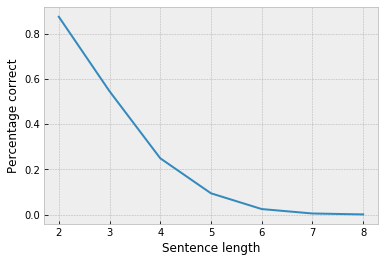

In [33]:
x = sorted(correct.keys())
y = [correct[slen] / total[slen] for slen in x]

plt.xlabel('Sentence length')
plt.ylabel('Percentage correct')
plt.plot(x, y)